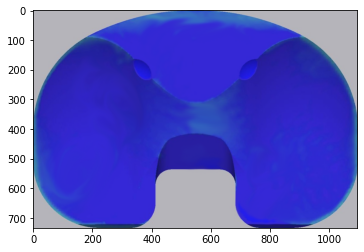

In [83]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# cv2.IMREAD_UNCHANGED, da preberemo tudi alpha kanal
base = cv2.imread('./obrabe_assets/base_image.png', cv2.IMREAD_UNCHANGED)
plt.imshow(cv2.cvtColor(base, cv2.COLOR_BGR2RGB))
plt.show()

Adding transparent overlay to the base image

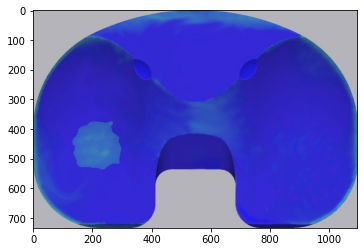

In [91]:
def add_transparent_image(background, foreground, opacity=1, x_offset=None, y_offset=None):
    bg_h, bg_w, bg_channels = background.shape
    fg_h, fg_w, fg_channels = foreground.shape

    assert bg_channels == 3, f'background image should have exactly 3 channels (RGB). found:{bg_channels}'
    assert fg_channels == 4, f'foreground image should have exactly 4 channels (RGBA). found:{fg_channels}'

    # center by default
    if x_offset is None: x_offset = (bg_w - fg_w) // 2
    if y_offset is None: y_offset = (bg_h - fg_h) // 2

    w = min(fg_w, bg_w, fg_w + x_offset, bg_w - x_offset)
    h = min(fg_h, bg_h, fg_h + y_offset, bg_h - y_offset)

    if w < 1 or h < 1: return

    # clip foreground and background images to the overlapping regions
    bg_x = max(0, x_offset)
    bg_y = max(0, y_offset)
    fg_x = max(0, x_offset * -1)
    fg_y = max(0, y_offset * -1)
    foreground = foreground[fg_y:fg_y + h, fg_x:fg_x + w]
    background_subsection = background[bg_y:bg_y + h, bg_x:bg_x + w]

    # separate alpha and color channels from the foreground image
    foreground_colors = foreground[:, :, :3]
    alpha_channel = foreground[:, :, 3] / 255  # 0-255 => 0.0-1.0
    alpha_channel = np.multiply(alpha_channel, opacity) # Transparency


    # construct an alpha_mask that matches the image shape
    alpha_mask = np.dstack((alpha_channel, alpha_channel, alpha_channel))

    # combine the background with the overlay image weighted by alpha
    composite = background_subsection * (1 - alpha_mask) + foreground_colors * alpha_mask

    # overwrite the section of the background image that has been updated
    background[bg_y:bg_y + h, bg_x:bg_x + w] = composite


overlay = cv2.imread('./obrabe_assets/minimalShift/L/1.png', cv2.IMREAD_UNCHANGED)

# zdruzeno = base[:, :, :3] * (1 - overlay[:, :, 3:] / 255) + overlay[:, :, :3] * (overlay[:, :, 3:] / 255)
zdruzeno = base[:, :, :3]
add_transparent_image(zdruzeno, overlay, 1, 100, 100)

# https://linuxtut.com/en/923aefb052f217f2f3c5/
# png_image [:,:, 3:] is the alpha channel retrieval. The range of the alpha channel is 0-255,
# so divide by 255 to get a ratio of 0-1. You can get the final image by multiplying the image
# to be drawn by the calculated ratio, multiplying the background by the "remaining" of the ratio,
# and adding them together.

cv2.imwrite('./slike_generirane/zdruzeno.png', zdruzeno)
zdruzeno = zdruzeno.astype(np.uint8) # Because component values became float
plt.imshow(cv2.cvtColor(zdruzeno, cv2.COLOR_BGR2RGB))
plt.show()

Turning it into a function

In [25]:
import random

def overlay_image(base, overlay, opacity=1):
  zdruzeno = base[:, :, :3] * (1 - overlay[:, :, 3:] / 255) + overlay[:, :, :3] * (overlay[:, :, 3:] / 255 * opacity)
  zdruzeno = zdruzeno.astype(np.uint8) # Because component values became float
  return zdruzeno

def generate(class_name, edges, large_patches, minimal_shift_left, minimal_shift_right, small_patches, num_small_patches, x_shift, y_shift, max_offset, img_name):
  """Generate random image with given parameters

  Args:
      class_name (string): Which class this image is going to belong to
      edges (array of overlays): array of overlays that are not to be shifted
      large_patches (array of overlays): array of overlays that are not to be shifted
      minimal_shift (array of overlays): array of overlays that are to be shifted slighly (x_shift/2)
      small_patches (array of overlays): array of overlays that are not to be shifted more (x_shift)
      num_small_patches (int): number of small patches to be placed
      x_shift (int): shift amount in pixels horizontally
      y_shift (int): shift amount in pixels vertically
      max_offset (int): maximum random offset in pixels
      img_name (string): name of the image to be saved
  """
  print("Generating image for class: " + class_name)
  # print("Random offset: " + str(random.randint(0, max_offset)))
  image = cv2.imread('./obrabe_assets/base_image.png', cv2.IMREAD_UNCHANGED)

  # edges
  for i in range(len(edges)):
    if random.choice([0, 1]) == 1:
      image = overlay_image(image, edges[i])

  cv2.imwrite('./slike_generirane/' + class_name + '/' + img_name + '.png', image)
  

Loading overlays

In [26]:
import os

def naloziSlike(mapa):
  images = []
  for filename in os.listdir(mapa):
    img = cv2.imread(os.path.join(mapa, filename), cv2.IMREAD_UNCHANGED)
    if img is not None:
      images.append(img)
  return images

# Load all overlays
edges = naloziSlike('./obrabe_assets/fixedPosition/edges/')
large_patches = naloziSlike('./obrabe_assets/fixedPosition/largeArea/')
minimal_shift_left = naloziSlike('./obrabe_assets/minimalShift/L')
minimal_shift_right = naloziSlike('./obrabe_assets/minimalShift/R')
small_patches = naloziSlike('./obrabe_assets/smallPatch/')

Generate images for different classes with the following rules for generating them:

![Rules table for generating images](rules_table_asset_use.jpg)

In [27]:
generate('razred1', edges, large_patches[:4], minimal_shift_left[:1], minimal_shift_right[:1], None, 0, 10, 10, 10, str(1))
generate('razred2', edges, large_patches[4:8], minimal_shift_left[1:2], minimal_shift_right[1:2], small_patches, 1, 5, 20, 5, str(1))
generate('razred3', edges, large_patches[8:], minimal_shift_left[2:3], minimal_shift_right[2:], small_patches, 2, -10, -10, 20, str(1))
generate('razred4', edges[:1], None, minimal_shift_left[3:4], None, small_patches, 3, -10, 10, 15, str(1))
generate('razred5', edges[8:], None, None, None, small_patches, 4, -15, -5, 10, str(1))

Generating image for class: razred1
Generating image for class: razred2
Generating image for class: razred3
Generating image for class: razred4
Generating image for class: razred5
